In [84]:
#기본 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib as mlt
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

In [85]:
##딥러닝 라이브러리 불러오기
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, concatenate,LSTM, GRU, Dense, Dropout, Bidirectional, LayerNormalization, MultiHeadAttention, Conv1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [86]:
##데이터 불러오기
df = pd.read_csv("C:/Users/theil/Desktop/data/12등_금속제창.csv", encoding='UTF8', parse_dates = ['납품요구접수일자'])

In [87]:
def preprocess(df, label = '납품요구접수일자', timesteps = 24, predict_size = 1):
    # 12일(timesteps) 전의 데이터를 참고 해 1일 뒤(predict_size)를 예측하는 dataset을 생성 - train 데이터
    df = df.iloc[:,:-1]
    forecast_idx = df.columns.to_list().index(label)
    split_ratio = 0.8


    split = int(df.shape[0]*split_ratio)
    train_dataset = df[:split]
    test_dataset = df[split:]
    # 정규화
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
    scaler = StandardScaler()
    train_scale = scaler.fit_transform(train_dataset) 
    test_scale = scaler.transform(test_dataset)
    def create_dataset(data, window_size, predict_size):
        X_list, y_list = [], []
        predict_size = predict_size - 1
        for i in range(len(data)):
            if (i + window_size+predict_size) < len(data):
                X_list.append(data[i:i+window_size, :])
                y_list.append(data[i+window_size+predict_size, forecast_idx])
        return np.array(X_list), np.array(y_list)


    train_X, train_y = create_dataset(train_scale, timesteps, predict_size)
    test_X, test_y = create_dataset(test_scale, timesteps, predict_size)
    train_y = train_y.reshape(train_y.shape[0],1)
    test_y = test_y.reshape(test_y.shape[0],1)

    return train_X, train_y, test_X, test_y, scaler

In [88]:
class Current():
    def __init__(self, df):
        self.df = df
        self.label = '납품요구접수일자'
        self.units = 128 # LSTM 노드 수
        self.dropout_rate = 0.2 # 랜덤으로 Dropout 할 비율
        self.train_X, self.train_y, self.test_X, self.test_y, self.scaler = preprocess(self.df, label=self.label, timesteps=12, predict_size=1)
        self.input_shape = (self.train_X.shape[1],self.train_X.shape[2])
    
    def inverse_transform(self, x):
        # 정규화 했던 것을 원래 값으로 돌려주는 함수
        array = np.concatenate((np.zeros((len(x), self.train_X.shape[2] - 1)), x), axis=1)
        array_transform = self.scaler.inverse_transform(array)[:,-1]

        return array_transform

    def uncertainty_loss(self,true,pred):
        # uncertainty 손실 함수
        mean = pred[:,:self.train_y.shape[-1]]
        var = pred[:,self.train_y.shape[-1]:]
        uncertainty = tf.math.exp(-1*var)
        return 0.5*uncertainty * (true-mean)**2 + 0.5*var

    def LSTM(self):
        inputs = Input(shape=self.input_shape)
        # 양방향 LSTM 2층
        x = Bidirectional(LSTM(self.units,activation='relu',input_shape=self.input_shape , return_sequences=True, dropout=self.dropout_rate, recurrent_dropout = self.dropout_rate))(inputs, training = True)
        x = Bidirectional(LSTM(self.units,activation='relu',input_shape=self.input_shape , dropout=self.dropout_rate, recurrent_dropout = self.dropout_rate))(inputs, training = True)

        # 결과 값은 2개의 Dense 층으로 가는데 한 개는 평균, 한 개는 분산 값 계산을
        mean = Dropout(rate=0.2)(x, training=True)
        mean = Dense(self.train_y.shape[-1])(mean)
        var = Dropout(rate=0.2)(x, training=True)
        var = Dense(self.train_y.shape[-1])(var)
        outputs = concatenate([mean, var])
        model = Model(inputs,outputs)

        model.compile(loss=self.uncertainty_loss, optimizer=Adam())

        return model

    def transformer_encoder(self, inputs, key_dim, num_heads, ff_dim):
        # Normalization and Attention
        x = LayerNormalization(epsilon=1e-6)(inputs)
        x = MultiHeadAttention(key_dim=key_dim, num_heads=num_heads, dropout=self.dropout_rate)(x, x)
        x = Dropout(self.dropout_rate)(x, training = True)
        res = x + inputs

        # Feed Forward
        x = LayerNormalization(epsilon=1e-6)(res)
        x = Conv1D(filters=ff_dim, kernel_size=1, activation = 'relu')(x, training = True)
        x = Dropout(0.25)(x, training = True)
        x = Conv1D(filters=inputs.shape[-1], kernel_size=1, activation = 'relu')(x, training = True)

        return x + res    

    def Transfomer_LSTM(self, key_dim = 128, num_heads=2, ff_dim=128, num_blocks=1):
        # 인코더가 LSTM
        inputs = Input(shape=self.input_shape)
        x = Bidirectional(LSTM(self.units, return_sequences=True,activation = 'relu', dropout = self.dropout_rate, recurrent_dropout = self.dropout_rate))(inputs, training = True)
        x = Bidirectional(LSTM(self.units, return_sequences=True,activation = 'relu', dropout = self.dropout_rate, recurrent_dropout = self.dropout_rate))(x, training = True)

        for _ in range(num_blocks):
            x = self.transformer_encoder(x, key_dim, num_heads, ff_dim)

        avg_pool  = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])

        mean = Dropout(rate=0.25)(conc, training=True)
        mean = Dense(self.train_y.shape[-1], activation = 'linear')(mean)
        var = Dropout(rate=0.25)(conc, training=True)
        var = Dense(self.train_y.shape[-1], activation = 'linear')(var)
        outputs = concatenate([mean, var])
        model = Model(inputs,outputs)

        model.compile(loss=self.uncertainty_loss, optimizer=Adam())

        return model

    def Transfomer_Conv(self, key_dim = 256, num_heads=2, ff_dim=128, num_blocks=1):
        # 인코더가 CNN
        inputs = Input(shape=self.input_shape)
        x = Conv1D(filters=self.units, kernel_size=self.train_X.shape[1], strides = 1, activation = 'relu', padding='causal')(inputs, training = True)
        x = Dropout(0.2)(x, training = True)

        for _ in range(num_blocks):
            x = self.transformer_encoder(x, key_dim, num_heads, ff_dim)

        avg_pool  = GlobalAveragePooling1D()(x)
        max_pool = GlobalMaxPooling1D()(x)
        conc = concatenate([avg_pool, max_pool])
        
        mean = Dropout(rate=0.25)(conc, training=True)
        mean = Dense(self.train_y.shape[-1])(mean)
        var = Dropout(rate=0.25)(conc, training=True)
        var = Dense(self.train_y.shape[-1])(var)
        outputs = concatenate([mean, var])
        model = Model(inputs,outputs)

        model.compile(loss=self.uncertainty_loss, optimizer=Adam())
        #model.compile(loss= MSE, optimizer=Adam(), metrics = [MSE])

        return model

    def fit(self, model, epochs = 100, batch_size = 128, show_loss = True):
        # 모델 fitting
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
        #early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=50)
    
        history = model.fit(self.train_X, self.train_y, batch_size = batch_size ,epochs=epochs,validation_split=0.2, verbose=1)
        train_loss = model.evaluate(self.train_X, self.train_y)
        print('train loss: {}'.format(train_loss))

        if show_loss:
            plt.figure(figsize=(12,8))
            plt.plot(history.history['loss'], label = 'loss')
            plt.plot(history.history['val_loss'], label = 'val_loss')
            plt.legend()
            plt.title('Model Loss')
            plt.show()
        return model

    def predict_ci(self, model, n_sample, ci=2.58, show= True):
        # 랜덤 샘플링과 99% 신뢰구간 구하기
        from tqdm import tqdm
        eps = np.array([model.predict(self.test_X)[:,:self.test_y.shape[-1]] for _ in tqdm(range(n_sample))])
        ale = np.array([model.predict(self.test_X)[:,self.test_y.shape[-1]:] for _ in tqdm(range(n_sample))])
    
        y_mean = np.mean(eps, axis=0) # predictive mean
        y_var = np.var(eps, axis=0) # epistemic uncertainty
        a_u = np.exp(np.mean(ale, axis=0)) # aleatoric uncertainty


        test_y_transfrom = self.inverse_transform(self.test_y)
        y_mean_transfrom = self.inverse_transform(y_mean.reshape(-1,1))
    

        #99% 신뢰구간
        lower = y_mean - ci*y_var**0.5
        upper = y_mean + ci*y_var**0.5
        lower_transfrom = self.inverse_transform(lower.reshape(-1,1))
        upper_transfrom = self.inverse_transform(upper.reshape(-1,1))

        tf_predict = self.df[-len(self.test_X):]
        tf_predict['predict'] = y_mean_transfrom
        tf_predict['predict_low'] = lower_transfrom
        tf_predict['predict_up'] = upper_transfrom

        under_upper = upper_transfrom[1:] >= test_y_transfrom[:-1]
        over_lower = lower_transfrom[1:] <= test_y_transfrom[:-1]
        total = (under_upper == over_lower)

        # 모델 평가
        from sklearn.metrics import mean_squared_error, r2_score
        print('rmse: {}'.format(np.sqrt(mean_squared_error(self.test_y, y_mean))))
        print('r2: {}'.format(r2_score(self.test_y, y_mean)))
        print("For Uncertainty model, {} are in 99% confidence interval".format(np.mean(total)))
        

        # 모델 그래프 결과
        if show == True:
            tx = self.df.index[-self.test_y.shape[0]:]
            #tx = range(self.test_y.shape[0])

            plt.figure(figsize=(12,8))
            plt.plot(tx, test_y_transfrom,'darkgreen')
            plt.plot(tx, y_mean_transfrom, 'orangered')
            plt.xlabel('Time')
            plt.ylabel('Test')
            plt.legend(['Test','Prediction'],loc='upper right')
            plt.title('Test Predict')
            plt.show() 
        
        return tf_predict

In [89]:
# current 클래스 생성
current = Current(df)

Epoch 1/150
4/4 [==============================] - 9s 807ms/step - loss: 0.9026 - val_loss: 1.3472
Epoch 2/150
4/4 [==============================] - 2s 566ms/step - loss: 0.5113 - val_loss: 0.5779
Epoch 3/150
4/4 [==============================] - 4s 925ms/step - loss: 0.1088 - val_loss: 0.9755
Epoch 4/150
4/4 [==============================] - 4s 883ms/step - loss: -0.1671 - val_loss: 0.1912
Epoch 5/150
4/4 [==============================] - 4s 874ms/step - loss: -0.4596 - val_loss: -0.1807
Epoch 6/150
4/4 [==============================] - 4s 887ms/step - loss: 0.1543 - val_loss: 0.2923
Epoch 7/150
4/4 [==============================] - 3s 859ms/step - loss: 0.2201 - val_loss: -0.1198
Epoch 8/150
4/4 [==============================] - 3s 860ms/step - loss: -0.2602 - val_loss: 1.0704
Epoch 9/150
4/4 [==============================] - 3s 859ms/step - loss: -0.3207 - val_loss: -0.2437
Epoch 10/150
4/4 [==============================] - 3s 841ms/step - loss: -0.4813 - val_loss: 0.3029
E

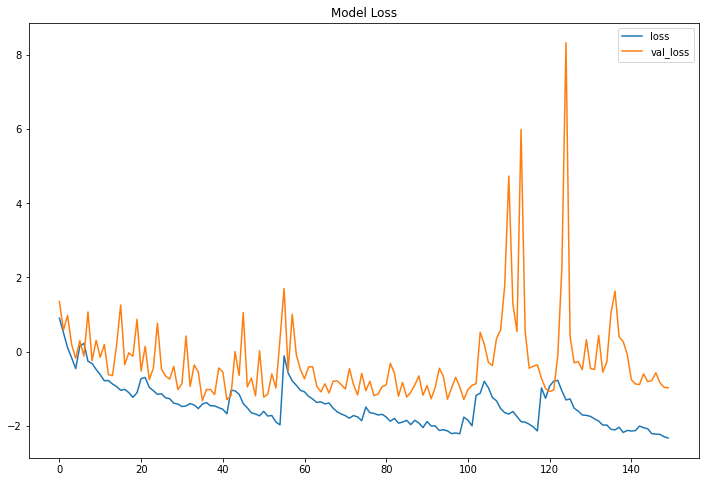

100%|██████████| 30/30 [00:18<00:00,  1.66it/s]

rmse: 1.8458825202785996
r2: -67.91435056254488
For Uncertainty model, 0.9633699633699634 are in 99% confidence interval


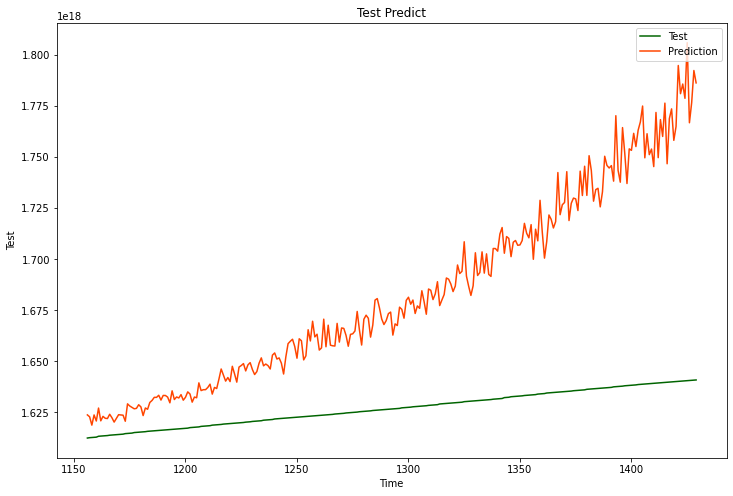

In [90]:
# 인코더가 LSTM인 Transformer LSTM 모델 with dropout uncertainty
# - 양방향 LSTM 2개와 FF layer 쌓은 트랜스포머 구조
# - key_dim : multihead attention 입력 차원
# - num_head : 병렬을 얼마나 할 것인지
# - ff_dim : FF 신경망 units
# - num_blocks : 트랜스포머 블록 층 (2개 이상이면 loss 크게 증가해서 1개로 한다)
model = current.Transfomer_LSTM(key_dim = 128, num_heads=2, ff_dim=128, num_blocks=1)

# 150번 반복, Adam optimizer
model = current.fit(model=model, epochs = 150, batch_size = 256, show_loss = True)

# Monte Carlo 샘플링 20번, 99% 신뢰구간 추정
TransformerLSTM_predict = current.predict_ci(model=model, n_sample = 30, ci=2.58, show= True)

Epoch 1/150
4/4 [==============================] - 1s 164ms/step - loss: 1.1089 - val_loss: 0.9371
Epoch 2/150
4/4 [==============================] - 0s 120ms/step - loss: 0.5824 - val_loss: 1.9483
Epoch 3/150
4/4 [==============================] - 1s 131ms/step - loss: 0.4209 - val_loss: 0.4123
Epoch 4/150
4/4 [==============================] - 1s 129ms/step - loss: 0.2558 - val_loss: 0.4048
Epoch 5/150
4/4 [==============================] - 1s 130ms/step - loss: 0.0129 - val_loss: 0.3443
Epoch 6/150
4/4 [==============================] - 1s 136ms/step - loss: -0.2109 - val_loss: 0.5605
Epoch 7/150
4/4 [==============================] - 1s 133ms/step - loss: -0.2806 - val_loss: -0.1600
Epoch 8/150
4/4 [==============================] - 1s 128ms/step - loss: -0.4168 - val_loss: -0.1937
Epoch 9/150
4/4 [==============================] - 1s 129ms/step - loss: -0.5177 - val_loss: -0.4255
Epoch 10/150
4/4 [==============================] - 1s 140ms/step - loss: -0.5706 - val_loss: -0.1215


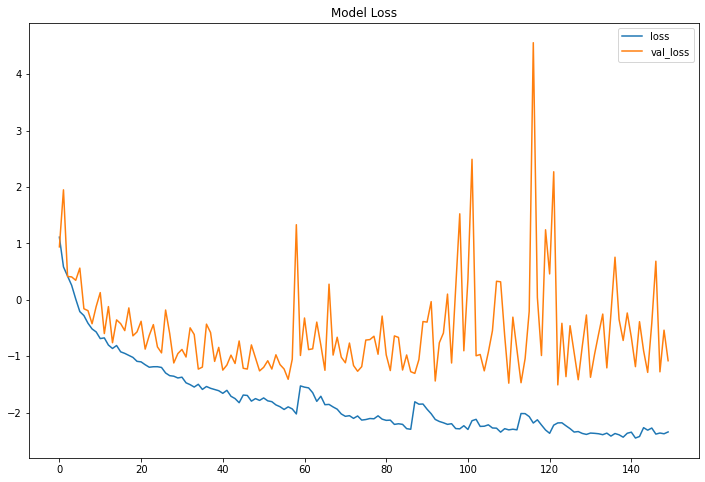

100%|██████████| 30/30 [00:03<00:00,  8.81it/s]


rmse: 0.33201075623768395
r2: -1.2294917060436399
For Uncertainty model, 0.7326007326007326 are in 99% confidence interval


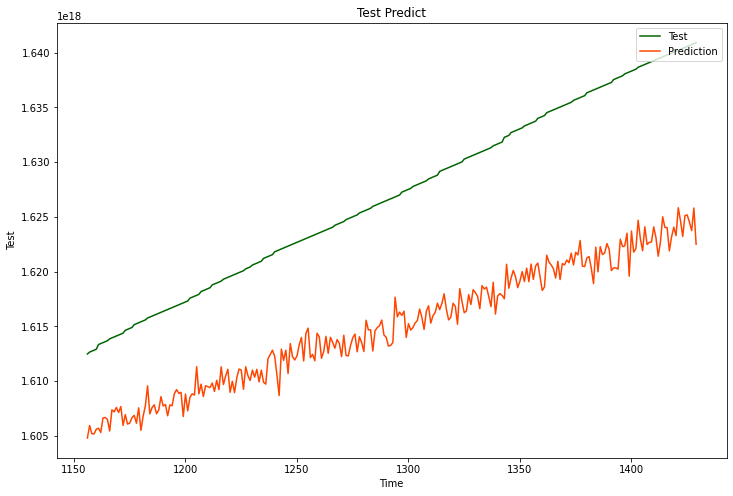

In [91]:
# 인코더가 CNN인 Transformer LSTM 모델 with dropout
model2 = current.Transfomer_Conv(key_dim = 128, num_heads=2, ff_dim=128, num_blocks=1)
model2 = current.fit(model=model2, epochs = 150, batch_size = 256, show_loss = True)
Conv_predict = current.predict_ci(model=model2, n_sample = 30, ci=2.58, show= True)

Epoch 1/150
4/4 [==============================] - 4s 355ms/step - loss: 0.3119 - val_loss: 0.5269
Epoch 2/150
4/4 [==============================] - 1s 217ms/step - loss: 0.1623 - val_loss: 0.2037
Epoch 3/150
4/4 [==============================] - 1s 223ms/step - loss: 0.0265 - val_loss: -0.1946
Epoch 4/150
4/4 [==============================] - 1s 226ms/step - loss: -0.1092 - val_loss: 0.1581
Epoch 5/150
4/4 [==============================] - 1s 225ms/step - loss: -0.2013 - val_loss: 4.1200
Epoch 6/150
4/4 [==============================] - 1s 223ms/step - loss: -0.3911 - val_loss: 8.0706
Epoch 7/150
4/4 [==============================] - 1s 223ms/step - loss: -0.6541 - val_loss: 4938276.5000
Epoch 8/150
4/4 [==============================] - 1s 228ms/step - loss: -0.8159 - val_loss: 219.2440
Epoch 9/150
4/4 [==============================] - 1s 220ms/step - loss: -0.8092 - val_loss: 15.3778
Epoch 10/150
4/4 [==============================] - 1s 221ms/step - loss: -0.8727 - val_loss:

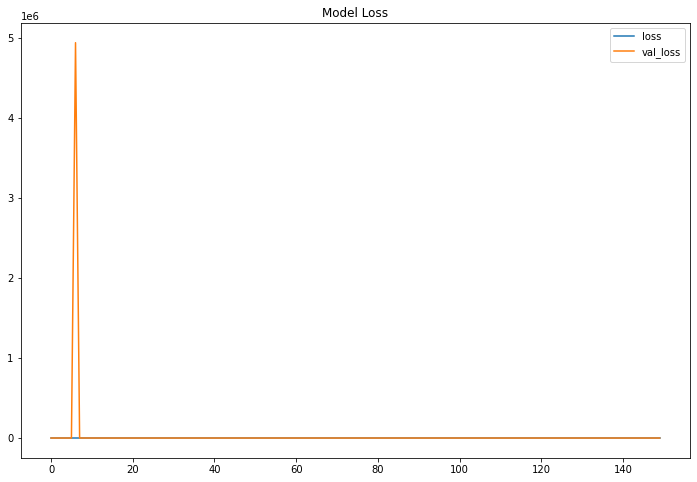

100%|██████████| 30/30 [00:05<00:00,  5.54it/s]

rmse: 0.35286586278023774
r2: -1.518377580125959
For Uncertainty model, 0.9523809523809523 are in 99% confidence interval


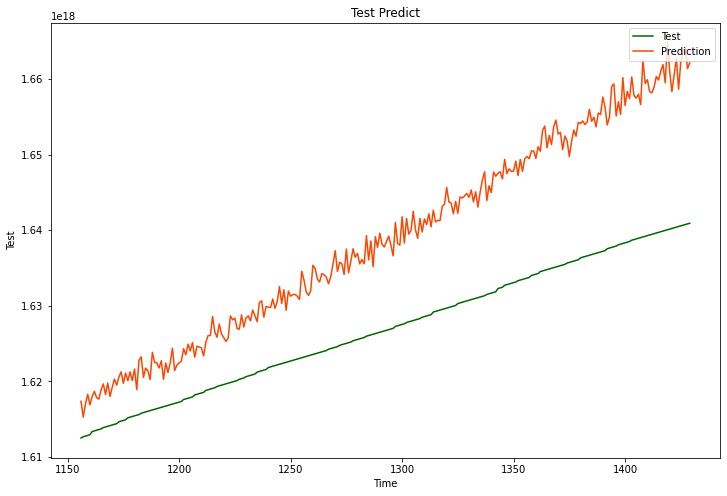

In [92]:
# 양방향 LSTM 모델 with dropout
model3 = current.LSTM()
model3 = current.fit(model=model3, epochs = 150, batch_size = 256, show_loss = True)
LSTM_predict = current.predict_ci(model=model3, n_sample = 30, ci=2.58, show= True)